In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
G = ox.graph_from_place('London, UK', network_type='drive')

In [3]:
N, E = ox.graph_to_gdfs(G)

In [4]:
E = E.reset_index()
E = E.drop('geometry', axis=1)

E.head()

u           v  key      osmid               name       highway  \
0  78112    25508583    0  129375498       Outer Circle  unclassified   
1  78112    25508584    0  129375498       Outer Circle  unclassified   
2  78112    25508584    1    4257258  Cambridge Terrace   residential   
3  99936  2146383887    0  204647020          York Gate  unclassified   
4  99936  4544836433    0  233623258          York Gate  unclassified   

  maxspeed      access  oneway   length lanes  ref bridge junction tunnel  \
0   20 mph  permissive   False   19.391   NaN  NaN    NaN      NaN    NaN   
1   20 mph  permissive   False   63.845   NaN  NaN    NaN      NaN    NaN   
2   20 mph  permissive    True  102.544   NaN  NaN    NaN      NaN    NaN   
3   20 mph  permissive   False    8.052   NaN  NaN    NaN      NaN    NaN   
4   20 mph  permissive    True   46.768   NaN  NaN    NaN      NaN    NaN   

  width est_width service area  
0   NaN       NaN     NaN  NaN  
1   NaN       NaN     NaN  NaN  
2   NaN       NaN     NaN  NaN  
3   NaN       NaN     NaN  NaN  
4   NaN       NaN     NaN  NaN

In [5]:
N = N.reset_index()
N = N.drop('geometry', axis=1)

In [6]:
N.to_csv("london_nodes.csv")
E.to_csv("london_edges.csv")

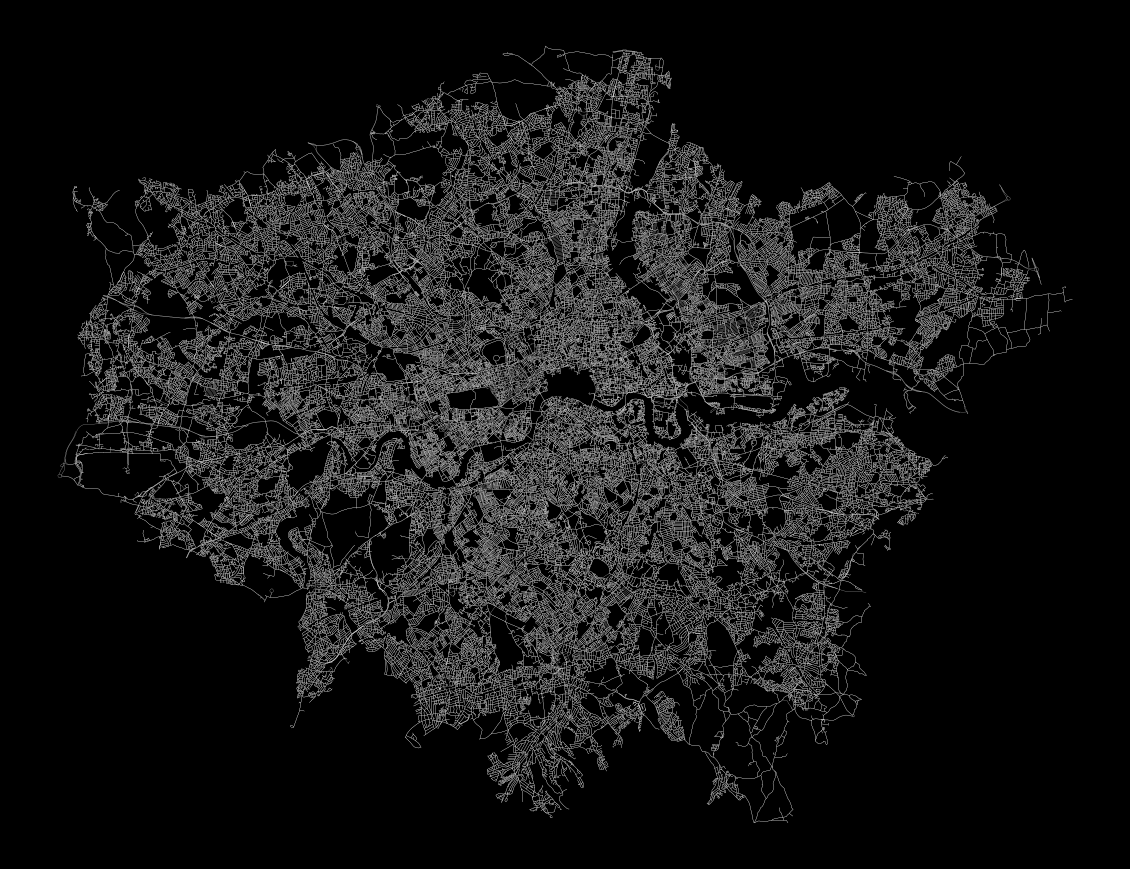

In [7]:
N, E = ox.graph_to_gdfs(G)

fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.2)
ax.set_axis_off()
ax.set_facecolor('k')

In [8]:
paths = ox.graph_from_point((51.52, -0.127), dist=5000, network_type='walk')

In [13]:
parks = ox.geometries_from_point((51.52, -0.127), dist=5000, tags={'leisure':'park'})

/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/osmnx/geometries.py:872: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` propert

In [14]:
parks = parks[parks.geometry.type!="Point"]
parks = parks.dissolve()
parks = parks.explode()

/var/folders/br/d_fg9g853bq1_bt73prjp3pr0000gn/T/ipykernel_38091/1327990030.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  parks = parks.explode()


In [15]:
parks = parks.to_crs(27700)

In [16]:
parks = parks[parks.geometry.area>250**2]

In [18]:
from shapely.geometry import Polygon

exteriors = list()

for i in parks.geometry.exterior:
    exterior = Polygon(i)
    exteriors.append(exterior)

In [19]:
parks['geometry'] = exteriors

In [20]:
parks.explore()

In [21]:
N, E = ox.graph_to_gdfs(paths)

N = N.to_crs(27700)
E = E.to_crs(27700)

In [200]:
hyde_boundary = parks['geometry'].iloc[1]

In [201]:
possible_entrances = E.unary_union.intersection(hyde_boundary.convex_hull.boundary)
possible_entrances = possible_entrances.buffer(hyde_boundary.length / 100)

In [202]:
possible_entrances = gpd.GeoDataFrame(geometry=gpd.GeoSeries(possible_entrances))
possible_entrances = possible_entrances.explode()

/var/folders/br/d_fg9g853bq1_bt73prjp3pr0000gn/T/ipykernel_38091/896090897.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  possible_entrances = possible_entrances.explode()


In [203]:
possible_entrances['geometry'] = possible_entrances.centroid

In [204]:
possible_entrances.reset_index(drop=True, inplace=True)

In [207]:
from shapely.ops import nearest_points

def find_entrance(row, nodes_data, point_column='geometry', value_column='geometry'):
    
    row = row['geometry']
    
    nng = nearest_points(row, nodes_data.geometry.unary_union)
    nni = nodes_data.loc[N['geometry'] == nng[1]]
    nnv = nni.index[0]
    
    gdf = gpd.GeoSeries(nng[1], crs=27700).to_crs(4326)
    
    return pd.Series({'index': nnv, 'y': gdf.geometry.y[0], 'x': gdf.geometry.x[0]})

In [208]:
%time possible_entrances.apply(find_entrance, nodes_data=N, axis=1)

CPU times: user 11.8 s, sys: 6.99 ms, total: 11.8 s
Wall time: 11.8 s


index         x          y
0  7.350427e+08 -0.155684  51.503275
1  7.350094e+08 -0.154374  51.507853
2  7.567854e+09 -0.158500  51.511821
3  3.064617e+08 -0.173505  51.501803
4  2.637410e+07 -0.168788  51.512353
5  7.006666e+09 -0.180840  51.510863
6  8.611540e+07 -0.184108  51.502045
7  3.054883e+09 -0.188321  51.504140

In [262]:
import math
nodes = list()

for i in np.arange(0, parks.shape[0]):
    print(i)
    
    park_boundary = parks.geometry.iloc[i]
    
    possible_entrances = E.unary_union.intersection(park_boundary.convex_hull.boundary).buffer(math.sqrt(park_boundary.length))
    possible_entrances = gpd.GeoDataFrame(geometry=gpd.GeoSeries(possible_entrances)).explode(index_parts=True)
    
    possible_entrances['geometry'] = possible_entrances.centroid
    possible_entrances.reset_index(drop=True, inplace=True)
    
    temporary_nodes = possible_entrances.apply(find_entrance, nodes_data=N, axis=1)
    temporary_nodes['park'] = i
    
    nodes.append(temporary_nodes)
    
nodes = pd.concat(nodes, ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [263]:
nodes.reset_index(drop=True, inplace=True)
nodes.head()

index         x          y  park
0  9.196292e+08 -0.198851  51.499241     0
1  7.350427e+08 -0.155684  51.503275     1
2  7.350094e+08 -0.154374  51.507853     1
3  7.567854e+09 -0.158500  51.511821     1
4  3.064617e+08 -0.173505  51.501803     1

In [246]:
intersecting_nodes = N[~N.intersects(parks.geometry.unary_union.buffer(-10))].index
G_sub = paths.subgraph(intersecting_nodes)

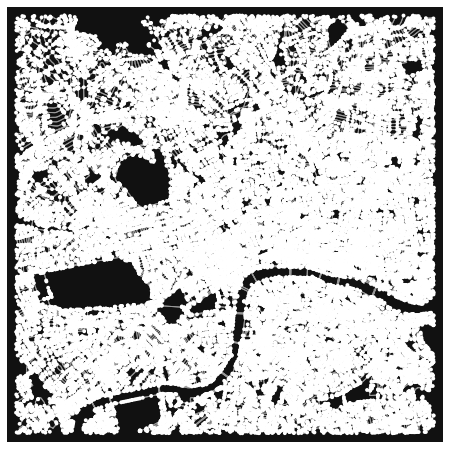

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [247]:
ox.plot_graph(G_sub)

In [248]:
N_sub, E_sub = ox.graph_to_gdfs(G_sub)

In [249]:
E_sub = E_sub.reset_index()
E_sub = E_sub.drop('geometry', axis=1)

E_sub.head()

u           v  key      osmid               name       highway  \
0  78112    25508583    0  129375498       Outer Circle  unclassified   
1  78112    25508584    0  129375498       Outer Circle  unclassified   
2  78112    25508584    1    4257258  Cambridge Terrace   residential   
3  99936  2146383892    0  204647016  York Terrace West       service   
4  99936  2146383887    0  204647020          York Gate  unclassified   

  maxspeed      access  oneway   length lanes  ref bridge junction service  \
0   20 mph  permissive   False   19.391   NaN  NaN    NaN      NaN     NaN   
1   20 mph  permissive   False   63.845   NaN  NaN    NaN      NaN     NaN   
2   20 mph  permissive   False  102.544   NaN  NaN    NaN      NaN     NaN   
3   20 mph  permissive   False   15.832   NaN  NaN    NaN      NaN     NaN   
4   20 mph  permissive   False    8.052   NaN  NaN    NaN      NaN     NaN   

  tunnel width est_width area  
0    NaN   NaN       NaN  NaN  
1    NaN   NaN       NaN  NaN  
2    NaN   NaN       NaN  NaN  
3    NaN   NaN       NaN  NaN  
4    NaN   NaN       NaN  NaN

In [250]:
N_sub = N_sub.reset_index()
N_sub = N_sub.drop('geometry', axis=1)

N_sub.head()

osmid          y         x  street_count highway  ref
0   78112  51.526976 -0.145792             3     NaN  NaN
1   99936  51.523611 -0.152791             4     NaN  NaN
2   99937  51.523018 -0.152024             3     NaN  NaN
3  101818  51.535179 -0.148104             4     NaN  NaN
4  101831  51.535612 -0.147044             3     NaN  NaN

In [264]:
entrances = nodes.rename(columns={'index': 'osmid'})
entrances['osmid'] = entrances.osmid.astype('int64')

entrances.head()

osmid         x          y  park
0   919629163 -0.198851  51.499241     0
1   735042687 -0.155684  51.503275     1
2   735009427 -0.154374  51.507853     1
3  7567853633 -0.158500  51.511821     1
4   306461682 -0.173505  51.501803     1

In [265]:
N_sub.to_csv("london_nodes.csv")
E_sub.to_csv("london_edges.csv")
entrances.to_csv("london_entrances.csv")

In [291]:
node_set = set(entrances[entrances.osmid.isin(N_sub.osmid)].osmid.unique())

In [347]:
%time lines = nx.multi_source_dijkstra_path(G_sub, node_set, weight='length')
%time cells = nx.voronoi_cells(G_sub, node_set, weight='length')

CPU times: user 888 ms, sys: 4.36 ms, total: 892 ms
Wall time: 891 ms
CPU times: user 899 ms, sys: 2.75 ms, total: 902 ms
Wall time: 904 ms


In [348]:
cells = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
cells = pd.concat(cells).merge(entrances, left_on='parent', right_on='osmid', how='left').drop(['x', 'y'], axis=1)

In [350]:
cells = cells.merge(N_sub, left_on='child', right_on='osmid', how='left')

In [378]:
from colorcet import palette
from matplotlib import colors
pal = palette['glasbey_category10']
col = colors.ListedColormap(pal)

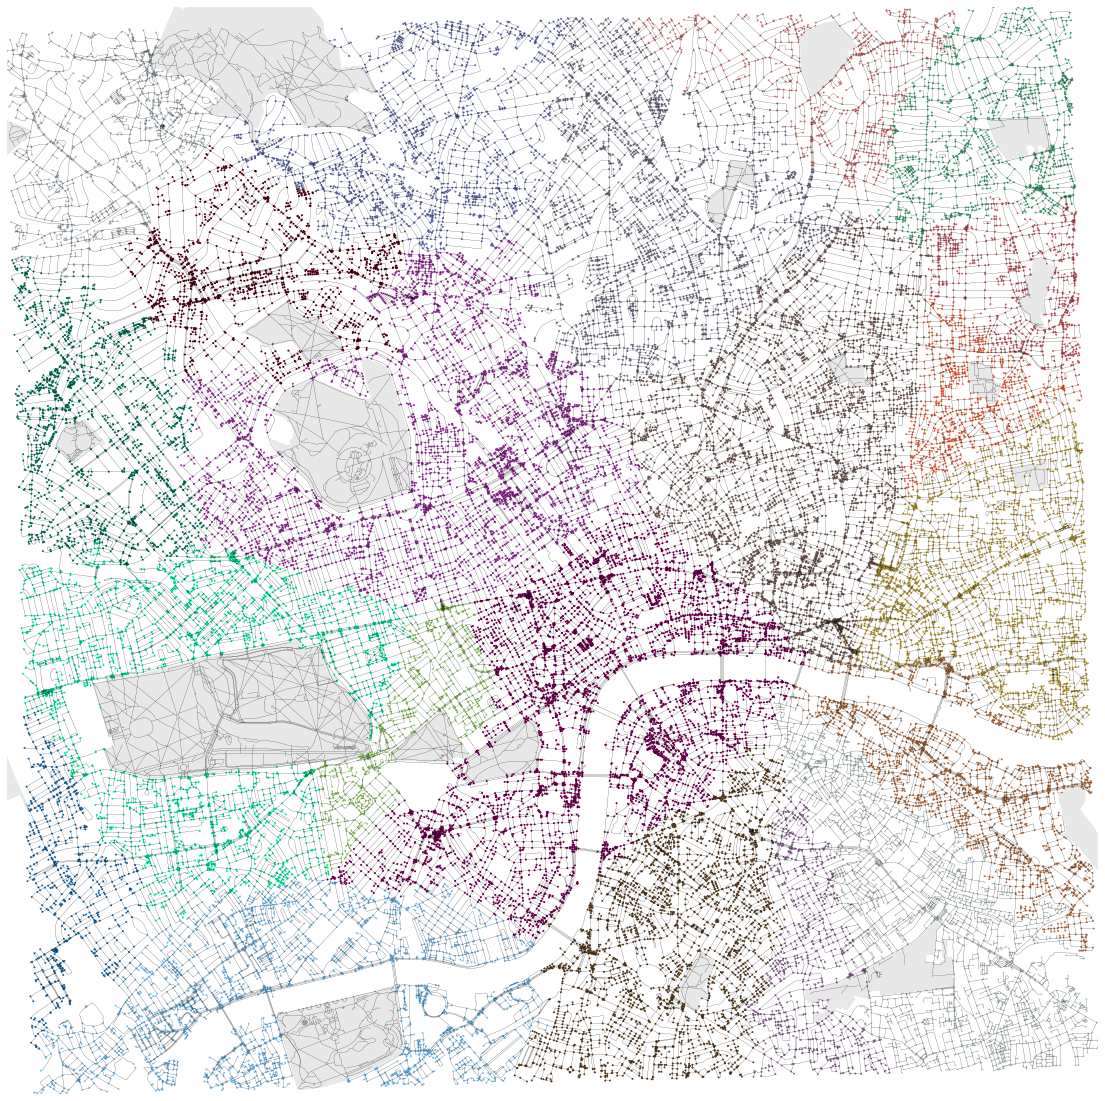

In [395]:
ax = E.plot(color='black', linewidth=0.1, figsize=(20, 20))
gpd.GeoDataFrame(cells, 
                 geometry=gpd.points_from_xy(cells.x, cells.y), 
                 crs=4326).to_crs(27700).plot('park', markersize=1, cmap=col, ax=ax)

parks.plot(color='lightgrey', alpha=0.5, ax=ax)

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))
ax.set_axis_off()

In [408]:
%time lengths = nx.multi_source_dijkstra_path_length(G_sub, node_set, weight="length")

CPU times: user 865 ms, sys: 4.86 ms, total: 870 ms
Wall time: 870 ms


In [414]:
lengths = pd.DataFrame({'osmid':lengths.keys(), 'distance': lengths.values()})

In [430]:
col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

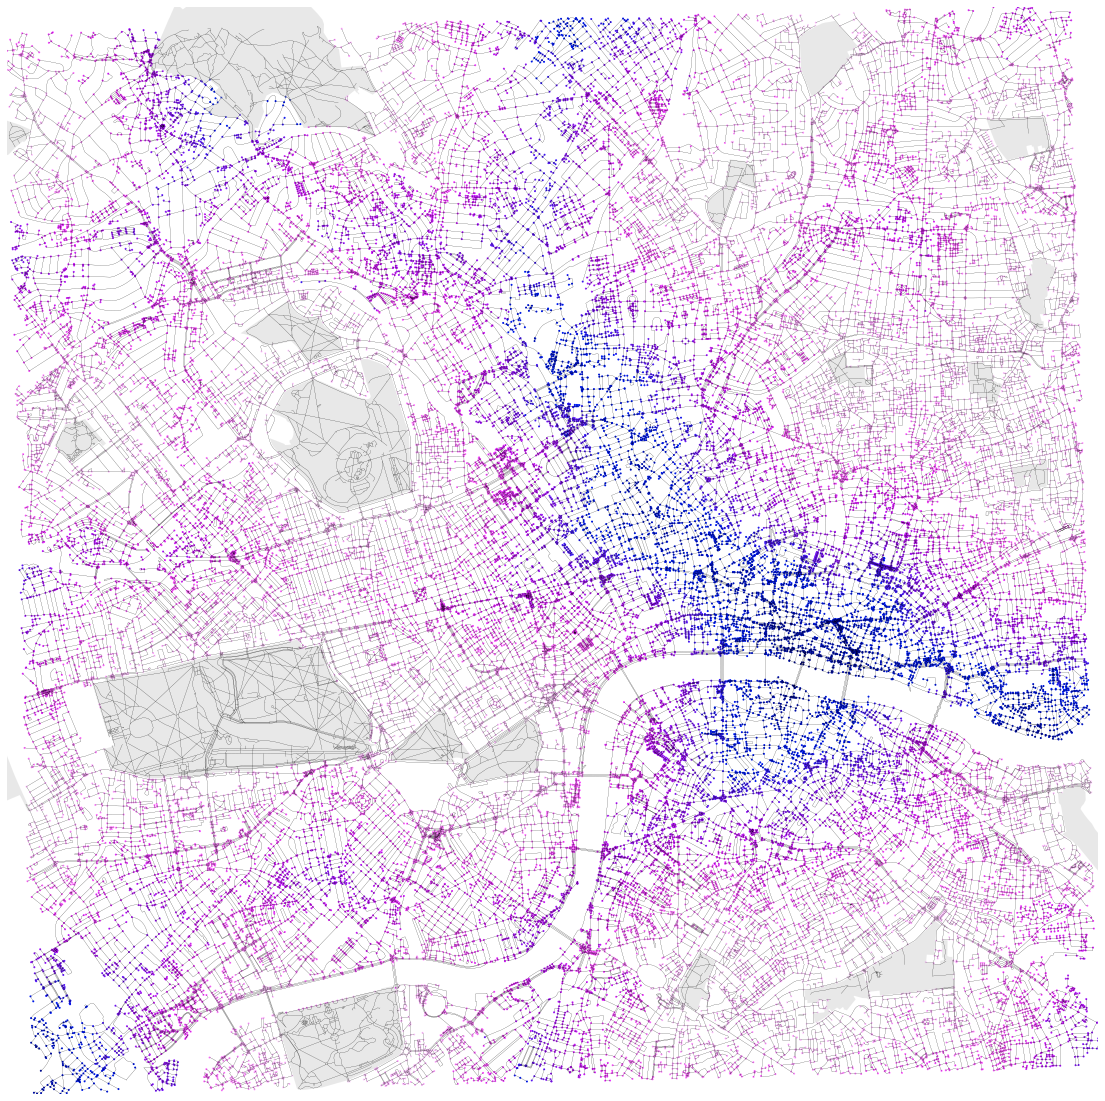

In [431]:
ax = E.plot(color='black', linewidth=0.1, figsize=(20, 20))
gpd.GeoDataFrame(cells, 
                 geometry=gpd.points_from_xy(cells.x, cells.y), 
                 crs=4326).merge(lengths, 
                                 left_on='child', 
                                 right_on='osmid',
                                 how='left').to_crs(27700).plot('distance', markersize=1, cmap=col, ax=ax)

parks.plot(color='lightgrey', alpha=0.5, ax=ax)

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))
ax.set_axis_off()

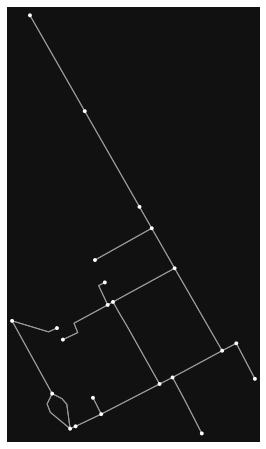

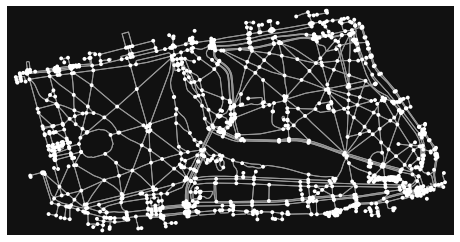

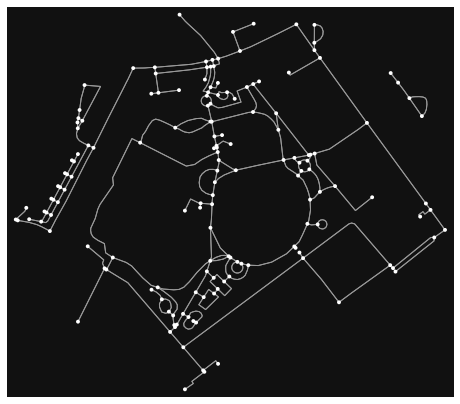

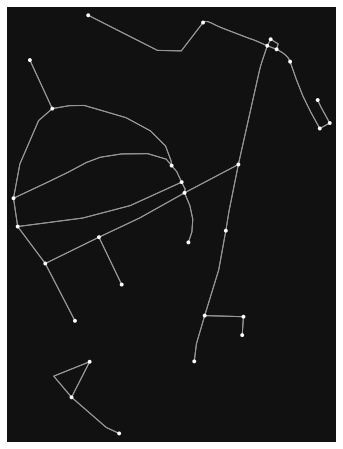

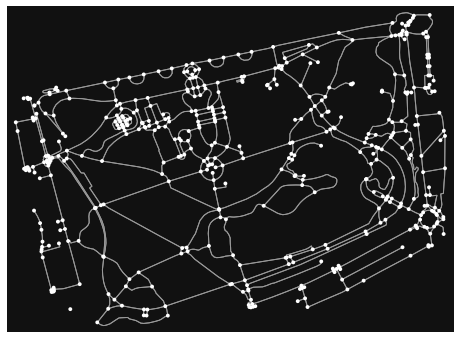

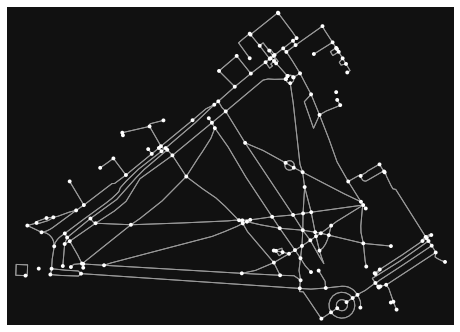

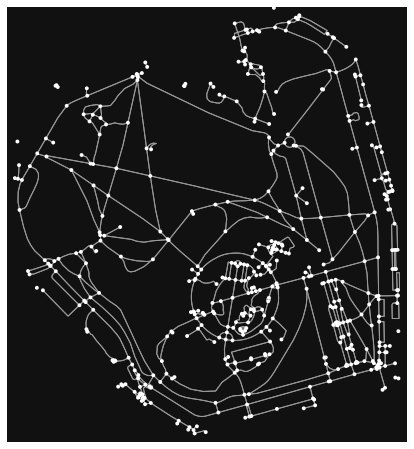

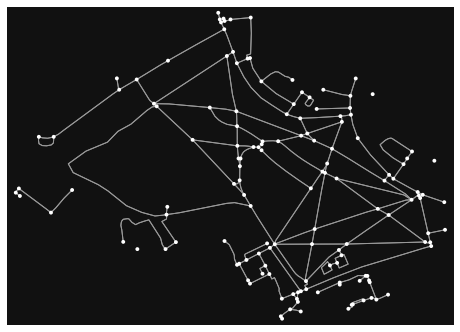

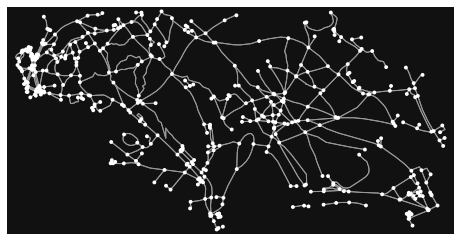

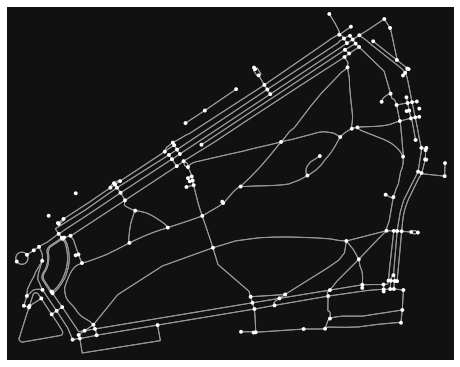

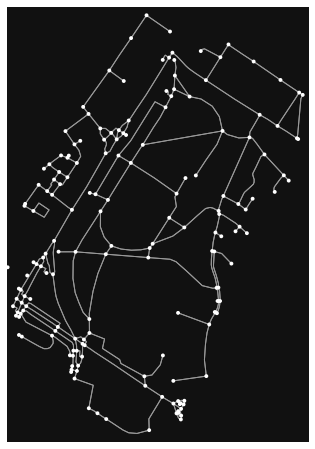

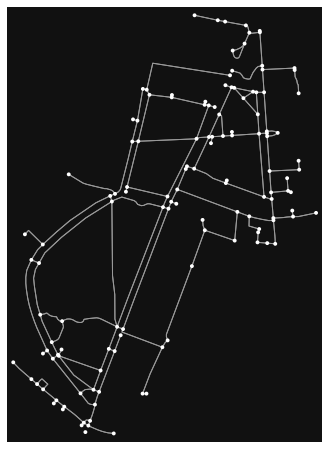

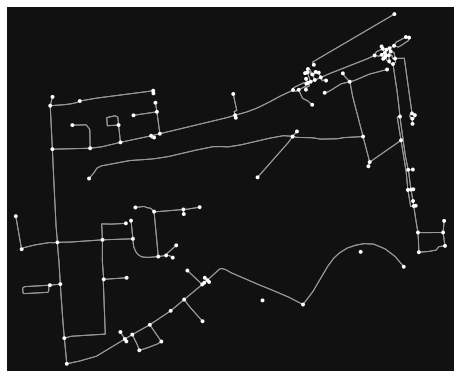

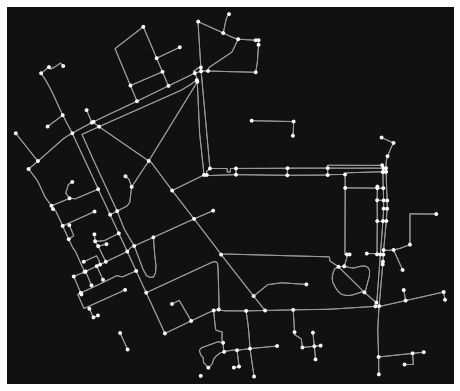

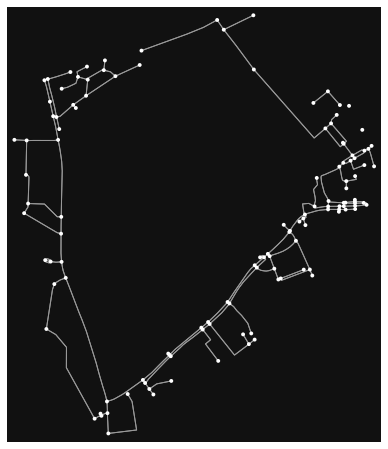

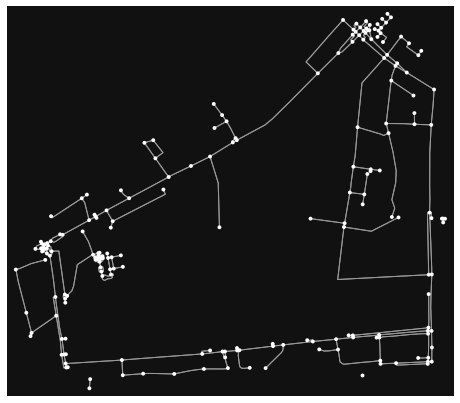

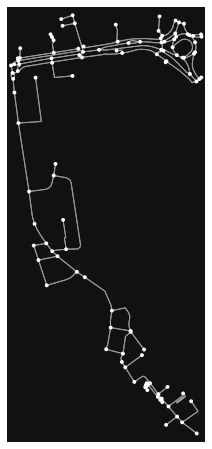

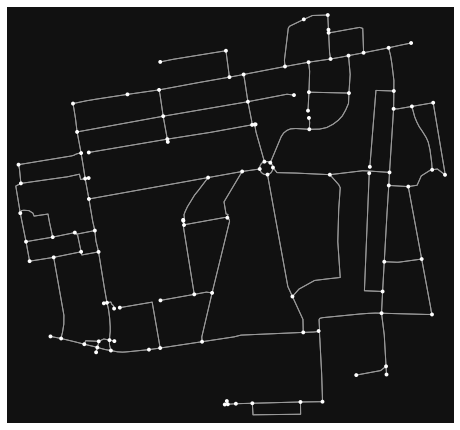

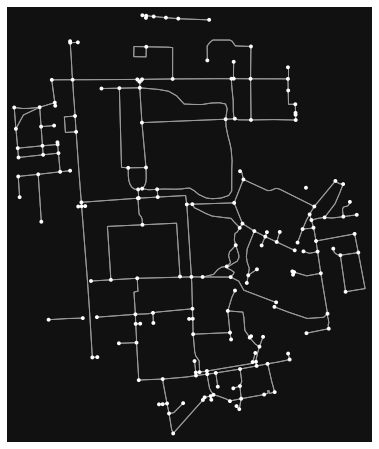

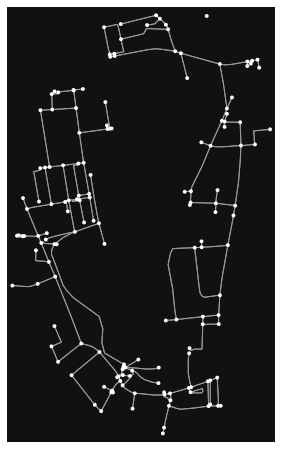

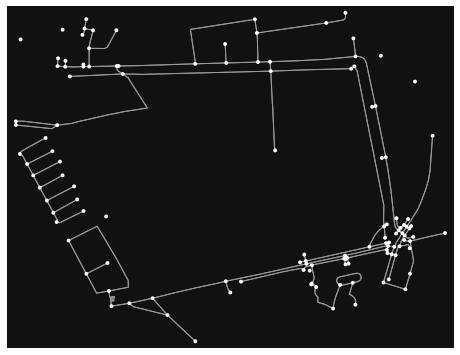

In [344]:
edges = list()
nodes = list()

graphs = list()

for polygon in parks['geometry']:
    inner = polygon.buffer(-100)
    outer = polygon.buffer(100)
    aoi = outer.difference(inner)

    intersecting_nodes = N[N.intersects(outer)].index
    G_sub = paths.subgraph(intersecting_nodes)
    try:
        fig, ax = ox.plot_graph(G_sub)
        
        N_temp, E_temp = ox.graph_to_gdfs(G_sub)
    
        nodes.append(N_temp)
        edges.append(E_temp)
    
        graphs.append(G_sub)
    except:
        pass

edges = gpd.GeoDataFrame(pd.concat(edges, ignore_index=False))
nodes = gpd.GeoDataFrame(pd.concat(nodes, ignore_index=False))